## 4) Compare optimization results

In this notebook we use the previously optimized parameters to assess the performance of different optimization strategies

In [171]:
%load_ext autoreload
%autoreload

#!nrnivmodl mechanisms
import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import matplotlib.pyplot as plt
import MEAutility as mu
import json
import numpy
import time
import numpy as np
import LFPy
from pathlib import Path
import pandas as pd
import os
import pickle

%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [172]:
import l5pc_model
import l5pc_evaluator
import l5pc_plot

In [173]:
sample_id = 3 # [0, ..., n_samples]
offspring_size = 250
max_ngen = 50
channels = [0, 6, 7, 10, 15]
nchannels=len(channels)

In [174]:
random_params_file = 'config/params/random.csv'
random_params = pd.read_csv(random_params_file, index_col='index')
gt_params = random_params.iloc[sample_id]

In [175]:
print(gt_params)

gNaTs2_tbar_NaTs2_t.apical         0.022013
gSKv3_1bar_SKv3_1.apical           0.004221
gImbar_Im.apical                   0.000167
gNaTa_tbar_NaTa_t.axonal           3.402216
gK_Tstbar_K_Tst.axonal             0.089102
gamma_CaDynamics_E2.axonal         0.003214
gNap_Et2bar_Nap_Et2.axonal         0.007379
gSK_E2bar_SK_E2.axonal             0.008446
gCa_HVAbar_Ca_HVA.axonal           0.000829
gK_Pstbar_K_Pst.axonal             0.817956
gSKv3_1bar_SKv3_1.axonal           1.041322
decay_CaDynamics_E2.axonal       268.950852
gCa_LVAstbar_Ca_LVAst.axonal       0.008235
gamma_CaDynamics_E2.somatic        0.000618
gSKv3_1bar_SKv3_1.somatic          0.310203
gSK_E2bar_SK_E2.somatic            0.009167
gCa_HVAbar_Ca_HVA.somatic          0.000925
gNaTs2_tbar_NaTs2_t.somatic        0.960017
decay_CaDynamics_E2.somatic      172.169473
gCa_LVAstbar_Ca_LVAst.somatic      0.000284
Name: random_3, dtype: float64


In [176]:
gt_params = gt_params.to_dict()

In [177]:
# get checkpoints
checkpoints_folder = Path('checkpoints/')
cp_soma_file = checkpoints_folder / f'random_{sample_id}' / f'soma_off{offspring_size}_ngen{max_ngen}_{nchannels}chan.pkl'
cp_bap_file = checkpoints_folder / f'random_{sample_id}' / f'bap_off{offspring_size}_ngen{max_ngen}_{nchannels}chan.pkl'
cp_extra_file = checkpoints_folder / f'random_{sample_id}' / f'extra_off{offspring_size}_ngen{max_ngen}_{nchannels}chan.pkl'

In [178]:
cp_soma = pickle.load(open(cp_soma_file, 'rb'))
cp_bap = pickle.load(open(cp_bap_file, 'rb'))
cp_extra = pickle.load(open(cp_extra_file, 'rb'))

In [179]:
hof_soma = cp_soma['halloffame']
hof_bap = cp_bap['halloffame']
hof_extra = cp_extra['halloffame']

In [180]:
cp_extra['generation']

50

In [181]:
prep = l5pc_evaluator.prepare_optimization('extra', sample_id, offspring_size=offspring_size, channels=channels,
                                           map_function = None)
evaluator = prep['evaluator']
fitness_calculator = prep['objectives_calculator']
fitness_protocols = prep['protocols']

MEA z positions:
[-500.          -26.31578947   52.63157895  289.47368421  684.21052632]
Number of features: 63


In [182]:
best_soma = best_params = evaluator.param_dict(hof_soma[0])
best_bap = best_params = evaluator.param_dict(hof_bap[0])
best_extra = best_params = evaluator.param_dict(hof_extra[0])

In [183]:
best_soma

{'gNaTs2_tbar_NaTs2_t.apical': 0.03166578783633319,
 'gSKv3_1bar_SKv3_1.apical': 0.010493986381075189,
 'gImbar_Im.apical': 0.00047712436025788233,
 'gNaTa_tbar_NaTa_t.axonal': 3.876247321998975,
 'gNap_Et2bar_Nap_Et2.axonal': 0.0051440531043948565,
 'gK_Pstbar_K_Pst.axonal': 0.4350006986228243,
 'gK_Tstbar_K_Tst.axonal': 0.033246279526380804,
 'gSK_E2bar_SK_E2.axonal': 0.008494399686917078,
 'gSKv3_1bar_SKv3_1.axonal': 1.038827611208197,
 'gCa_HVAbar_Ca_HVA.axonal': 0.000585931395755934,
 'gCa_LVAstbar_Ca_LVAst.axonal': 0.006920222246472119,
 'gamma_CaDynamics_E2.axonal': 0.004079110841736389,
 'decay_CaDynamics_E2.axonal': 216.67420046285648,
 'gNaTs2_tbar_NaTs2_t.somatic': 0.8846682651827729,
 'gSKv3_1bar_SKv3_1.somatic': 0.28068586877388624,
 'gSK_E2bar_SK_E2.somatic': 0.02618316508677737,
 'gCa_HVAbar_Ca_HVA.somatic': 0.00011415433335269319,
 'gCa_LVAstbar_Ca_LVAst.somatic': 0.0038091607841203596,
 'gamma_CaDynamics_E2.somatic': 0.0007365597225954572,
 'decay_CaDynamics_E2.somatic

In [184]:
best_bap

{'gNaTs2_tbar_NaTs2_t.apical': 0.022764858621799697,
 'gSKv3_1bar_SKv3_1.apical': 0.004084741315495018,
 'gImbar_Im.apical': 0.0004120872015933527,
 'gNaTa_tbar_NaTa_t.axonal': 3.299057390881077,
 'gNap_Et2bar_Nap_Et2.axonal': 0.012330200221466801,
 'gK_Pstbar_K_Pst.axonal': 0.6574192844011444,
 'gK_Tstbar_K_Tst.axonal': 0.017078754425895043,
 'gSK_E2bar_SK_E2.axonal': 0.059018228941714636,
 'gSKv3_1bar_SKv3_1.axonal': 0.9663237273291414,
 'gCa_HVAbar_Ca_HVA.axonal': 0.0003548920143595343,
 'gCa_LVAstbar_Ca_LVAst.axonal': 0.0023715268247396252,
 'gamma_CaDynamics_E2.axonal': 0.004207318257836828,
 'decay_CaDynamics_E2.axonal': 239.33401897860918,
 'gNaTs2_tbar_NaTs2_t.somatic': 0.9744035089466306,
 'gSKv3_1bar_SKv3_1.somatic': 0.33555491176660035,
 'gSK_E2bar_SK_E2.somatic': 0.0008352879962591946,
 'gCa_HVAbar_Ca_HVA.somatic': 0.00010950741719417703,
 'gCa_LVAstbar_Ca_LVAst.somatic': 0.0014945067421895794,
 'gamma_CaDynamics_E2.somatic': 0.004698863325008318,
 'decay_CaDynamics_E2.soma

In [185]:
best_extra

{'gNaTs2_tbar_NaTs2_t.apical': 0.021848055789877873,
 'gSKv3_1bar_SKv3_1.apical': 5.9455456648165386e-05,
 'gImbar_Im.apical': 0.000766874624503147,
 'gNaTa_tbar_NaTa_t.axonal': 3.7157390469994276,
 'gNap_Et2bar_Nap_Et2.axonal': 0.009917050207030483,
 'gK_Pstbar_K_Pst.axonal': 0.7480128931159115,
 'gK_Tstbar_K_Tst.axonal': 0.05286504933687434,
 'gSK_E2bar_SK_E2.axonal': 0.019530059874931657,
 'gSKv3_1bar_SKv3_1.axonal': 1.2366307724645507,
 'gCa_HVAbar_Ca_HVA.axonal': 0.00014288163863597448,
 'gCa_LVAstbar_Ca_LVAst.axonal': 0.0002877795895719213,
 'gamma_CaDynamics_E2.axonal': 0.02443000817966525,
 'decay_CaDynamics_E2.axonal': 169.59944736124675,
 'gNaTs2_tbar_NaTs2_t.somatic': 0.9212614371585947,
 'gSKv3_1bar_SKv3_1.somatic': 0.2990751903766871,
 'gSK_E2bar_SK_E2.somatic': 0.003953168841867333,
 'gCa_HVAbar_Ca_HVA.somatic': 0.00019737295957955098,
 'gCa_LVAstbar_Ca_LVAst.somatic': 0.001925284103394878,
 'gamma_CaDynamics_E2.somatic': 0.011191062369551093,
 'decay_CaDynamics_E2.somati

In [186]:
gt_params

{'gNaTs2_tbar_NaTs2_t.apical': 0.022013113379356263,
 'gSKv3_1bar_SKv3_1.apical': 0.004221221272415267,
 'gImbar_Im.apical': 0.00016732570226153616,
 'gNaTa_tbar_NaTa_t.axonal': 3.4022159973507797,
 'gK_Tstbar_K_Tst.axonal': 0.08910218914876478,
 'gamma_CaDynamics_E2.axonal': 0.00321439059444858,
 'gNap_Et2bar_Nap_Et2.axonal': 0.007378536737478389,
 'gSK_E2bar_SK_E2.axonal': 0.008445530606578247,
 'gCa_HVAbar_Ca_HVA.axonal': 0.0008286611576518412,
 'gK_Pstbar_K_Pst.axonal': 0.8179561382386326,
 'gSKv3_1bar_SKv3_1.axonal': 1.0413220057421255,
 'decay_CaDynamics_E2.axonal': 268.9508523624379,
 'gCa_LVAstbar_Ca_LVAst.axonal': 0.008234818176712374,
 'gamma_CaDynamics_E2.somatic': 0.0006175815237310988,
 'gSKv3_1bar_SKv3_1.somatic': 0.310203078367549,
 'gSK_E2bar_SK_E2.somatic': 0.009166506613608582,
 'gCa_HVAbar_Ca_HVA.somatic': 0.0009254938875024395,
 'gNaTs2_tbar_NaTs2_t.somatic': 0.9600173891046584,
 'decay_CaDynamics_E2.somatic': 172.16947307051296,
 'gCa_LVAstbar_Ca_LVAst.somatic': 0.

In [187]:
rel_error_soma = {}
rel_error_bap = {}
rel_error_extra = {}

for param, gt_value in gt_params.items():
    rel_error_soma[param] = np.abs((gt_value - best_soma[param]) / gt_value)
    rel_error_bap[param] = np.abs((gt_value - best_bap[param]) / gt_value)    
    rel_error_extra[param] = np.abs((gt_value - best_extra[param]) / gt_value)    

In [188]:
rel_error_soma

{'gNaTs2_tbar_NaTs2_t.apical': 0.43849655842090635,
 'gSKv3_1bar_SKv3_1.apical': 1.4860071775083274,
 'gImbar_Im.apical': 1.8514708368719086,
 'gNaTa_tbar_NaTa_t.axonal': 0.13933016746065252,
 'gK_Tstbar_K_Tst.axonal': 0.6268747171758833,
 'gamma_CaDynamics_E2.axonal': 0.2690152991304872,
 'gNap_Et2bar_Nap_Et2.axonal': 0.30283560448154195,
 'gSK_E2bar_SK_E2.axonal': 0.005786383664368797,
 'gCa_HVAbar_Ca_HVA.axonal': 0.29291799145470404,
 'gK_Pstbar_K_Pst.axonal': 0.4681857885930845,
 'gSKv3_1bar_SKv3_1.axonal': 0.0023954113330685992,
 'decay_CaDynamics_E2.axonal': 0.19437250873305825,
 'gCa_LVAstbar_Ca_LVAst.axonal': 0.15963873178862184,
 'gamma_CaDynamics_E2.somatic': 0.19265181080152052,
 'gSKv3_1bar_SKv3_1.somatic': 0.09515447025541392,
 'gSK_E2bar_SK_E2.somatic': 1.8563951558062353,
 'gCa_HVAbar_Ca_HVA.somatic': 0.8766557673754574,
 'gNaTs2_tbar_NaTs2_t.somatic': 0.07848724906135131,
 'decay_CaDynamics_E2.somatic': 1.353629883887917,
 'gCa_LVAstbar_Ca_LVAst.somatic': 12.43118295140

In [189]:
rel_error_bap

{'gNaTs2_tbar_NaTs2_t.apical': 0.03414988282159198,
 'gSKv3_1bar_SKv3_1.apical': 0.0323318651434159,
 'gImbar_Im.apical': 1.4627848323579447,
 'gNaTa_tbar_NaTa_t.axonal': 0.030321004471800014,
 'gK_Tstbar_K_Tst.axonal': 0.8083239638772466,
 'gamma_CaDynamics_E2.axonal': 0.30890074936850737,
 'gNap_Et2bar_Nap_Et2.axonal': 0.6710901714207146,
 'gSK_E2bar_SK_E2.axonal': 5.988101954866539,
 'gCa_HVAbar_Ca_HVA.axonal': 0.5717284307554804,
 'gK_Pstbar_K_Pst.axonal': 0.19626584645869208,
 'gSKv3_1bar_SKv3_1.axonal': 0.07202217757756366,
 'decay_CaDynamics_E2.axonal': 0.11011987180437377,
 'gCa_LVAstbar_Ca_LVAst.axonal': 0.712012241940426,
 'gamma_CaDynamics_E2.somatic': 6.608490773202357,
 'gSKv3_1bar_SKv3_1.somatic': 0.08172656935729315,
 'gSK_E2bar_SK_E2.somatic': 0.9088760820813541,
 'gCa_HVAbar_Ca_HVA.somatic': 0.8816767796384951,
 'gNaTs2_tbar_NaTs2_t.somatic': 0.014985270064107048,
 'decay_CaDynamics_E2.somatic': 0.7237662989669333,
 'gCa_LVAstbar_Ca_LVAst.somatic': 4.2696629557202215}

In [190]:
rel_error_extra

{'gNaTs2_tbar_NaTs2_t.apical': 0.007498148337035288,
 'gSKv3_1bar_SKv3_1.apical': 0.9859151054135226,
 'gImbar_Im.apical': 3.583125091592289,
 'gNaTa_tbar_NaTa_t.axonal': 0.09215259992098691,
 'gK_Tstbar_K_Tst.axonal': 0.4066919136115613,
 'gamma_CaDynamics_E2.axonal': 6.600198999417541,
 'gNap_Et2bar_Nap_Et2.axonal': 0.3440402290955632,
 'gSK_E2bar_SK_E2.axonal': 1.3124728077735743,
 'gCa_HVAbar_Ca_HVA.axonal': 0.8275753155356588,
 'gK_Pstbar_K_Pst.axonal': 0.08550977473356362,
 'gSKv3_1bar_SKv3_1.axonal': 0.18755847436762196,
 'decay_CaDynamics_E2.axonal': 0.36940356994037443,
 'gCa_LVAstbar_Ca_LVAst.axonal': 0.9650533158842843,
 'gamma_CaDynamics_E2.somatic': 17.120785579757392,
 'gSKv3_1bar_SKv3_1.somatic': 0.03587291283317583,
 'gSK_E2bar_SK_E2.somatic': 0.568737687266983,
 'gCa_HVAbar_Ca_HVA.somatic': 0.7867376951433073,
 'gNaTs2_tbar_NaTs2_t.somatic': 0.04037005202812912,
 'decay_CaDynamics_E2.somatic': 0.8811225751487594,
 'gCa_LVAstbar_Ca_LVAst.somatic': 5.7885932077046665}

In [193]:
print(np.sum(list(rel_error_soma.values())), 
      np.sum(list(rel_error_bap.values())), 
      np.sum(list(rel_error_extra.values())))

23.121484465212685 24.48733772189506 40.989415055505994


In [194]:
def plot_evolution(logbook, color, label=None, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    
    gens = []
    avgs = []
    stds = []
    mins = []
    maxs = []
    
    for log in logbook:
        gens.append(log['gen'])
        avgs.append(log['avg'])        
        stds.append(log['std'])        
        mins.append(log['min'])        
        maxs.append(log['max'])      
    
    gens = np.array(gens)
    avgs = np.array(avgs)
    stds = np.array(stds)
    mins = np.array(mins)
    maxs = np.array(maxs)
    
#     ax.plot(gens, avgs, color=color, label=label)
    ax.plot(gens, mins, color=color, label=label)
#     ax.plot(gens, maxs, color=color,  ls='--', alpha=0.3)
#     ax.fill(gens, avgs, mins, color=color, alpha=0.3)
    
    return ax

<IPython.core.display.Javascript object>


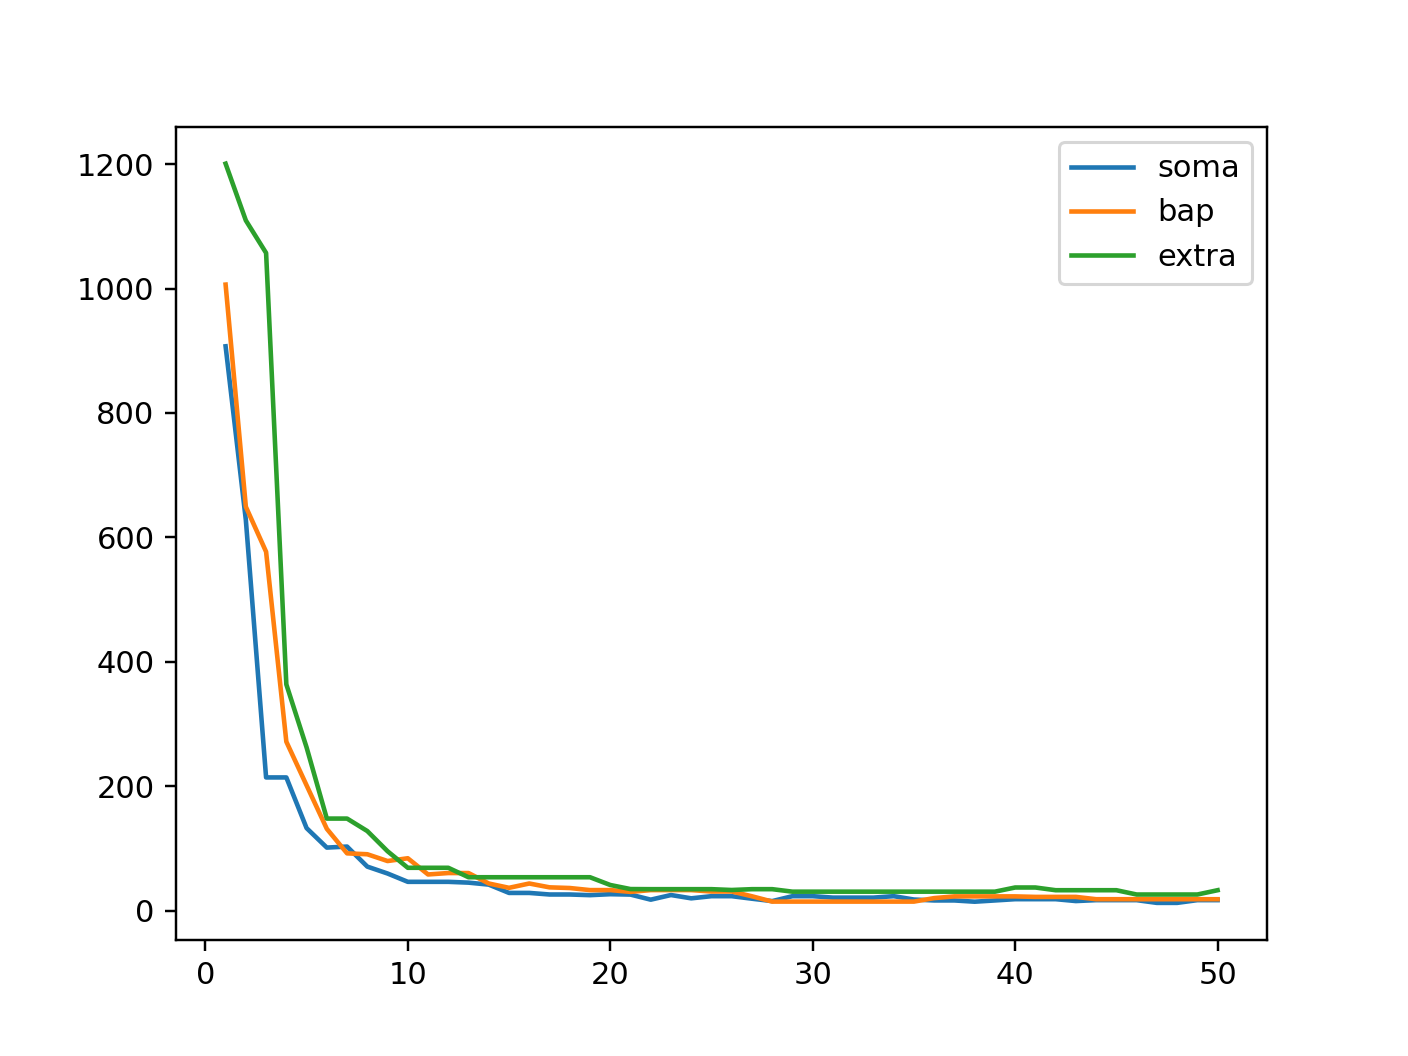

In [195]:
ax = plot_evolution(cp_soma['logbook'], color='C0', label='soma')
ax = plot_evolution(cp_bap['logbook'], color='C1', label='bap', ax=ax)
ax = plot_evolution(cp_extra['logbook'], color='C2', label='extra', ax=ax)
ax.legend()

In [196]:
original_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values=gt_params)
best_responses_soma = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values=best_soma)
best_responses_bap = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values=best_bap)
best_responses_extra = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values=best_extra)

<IPython.core.display.Javascript object>


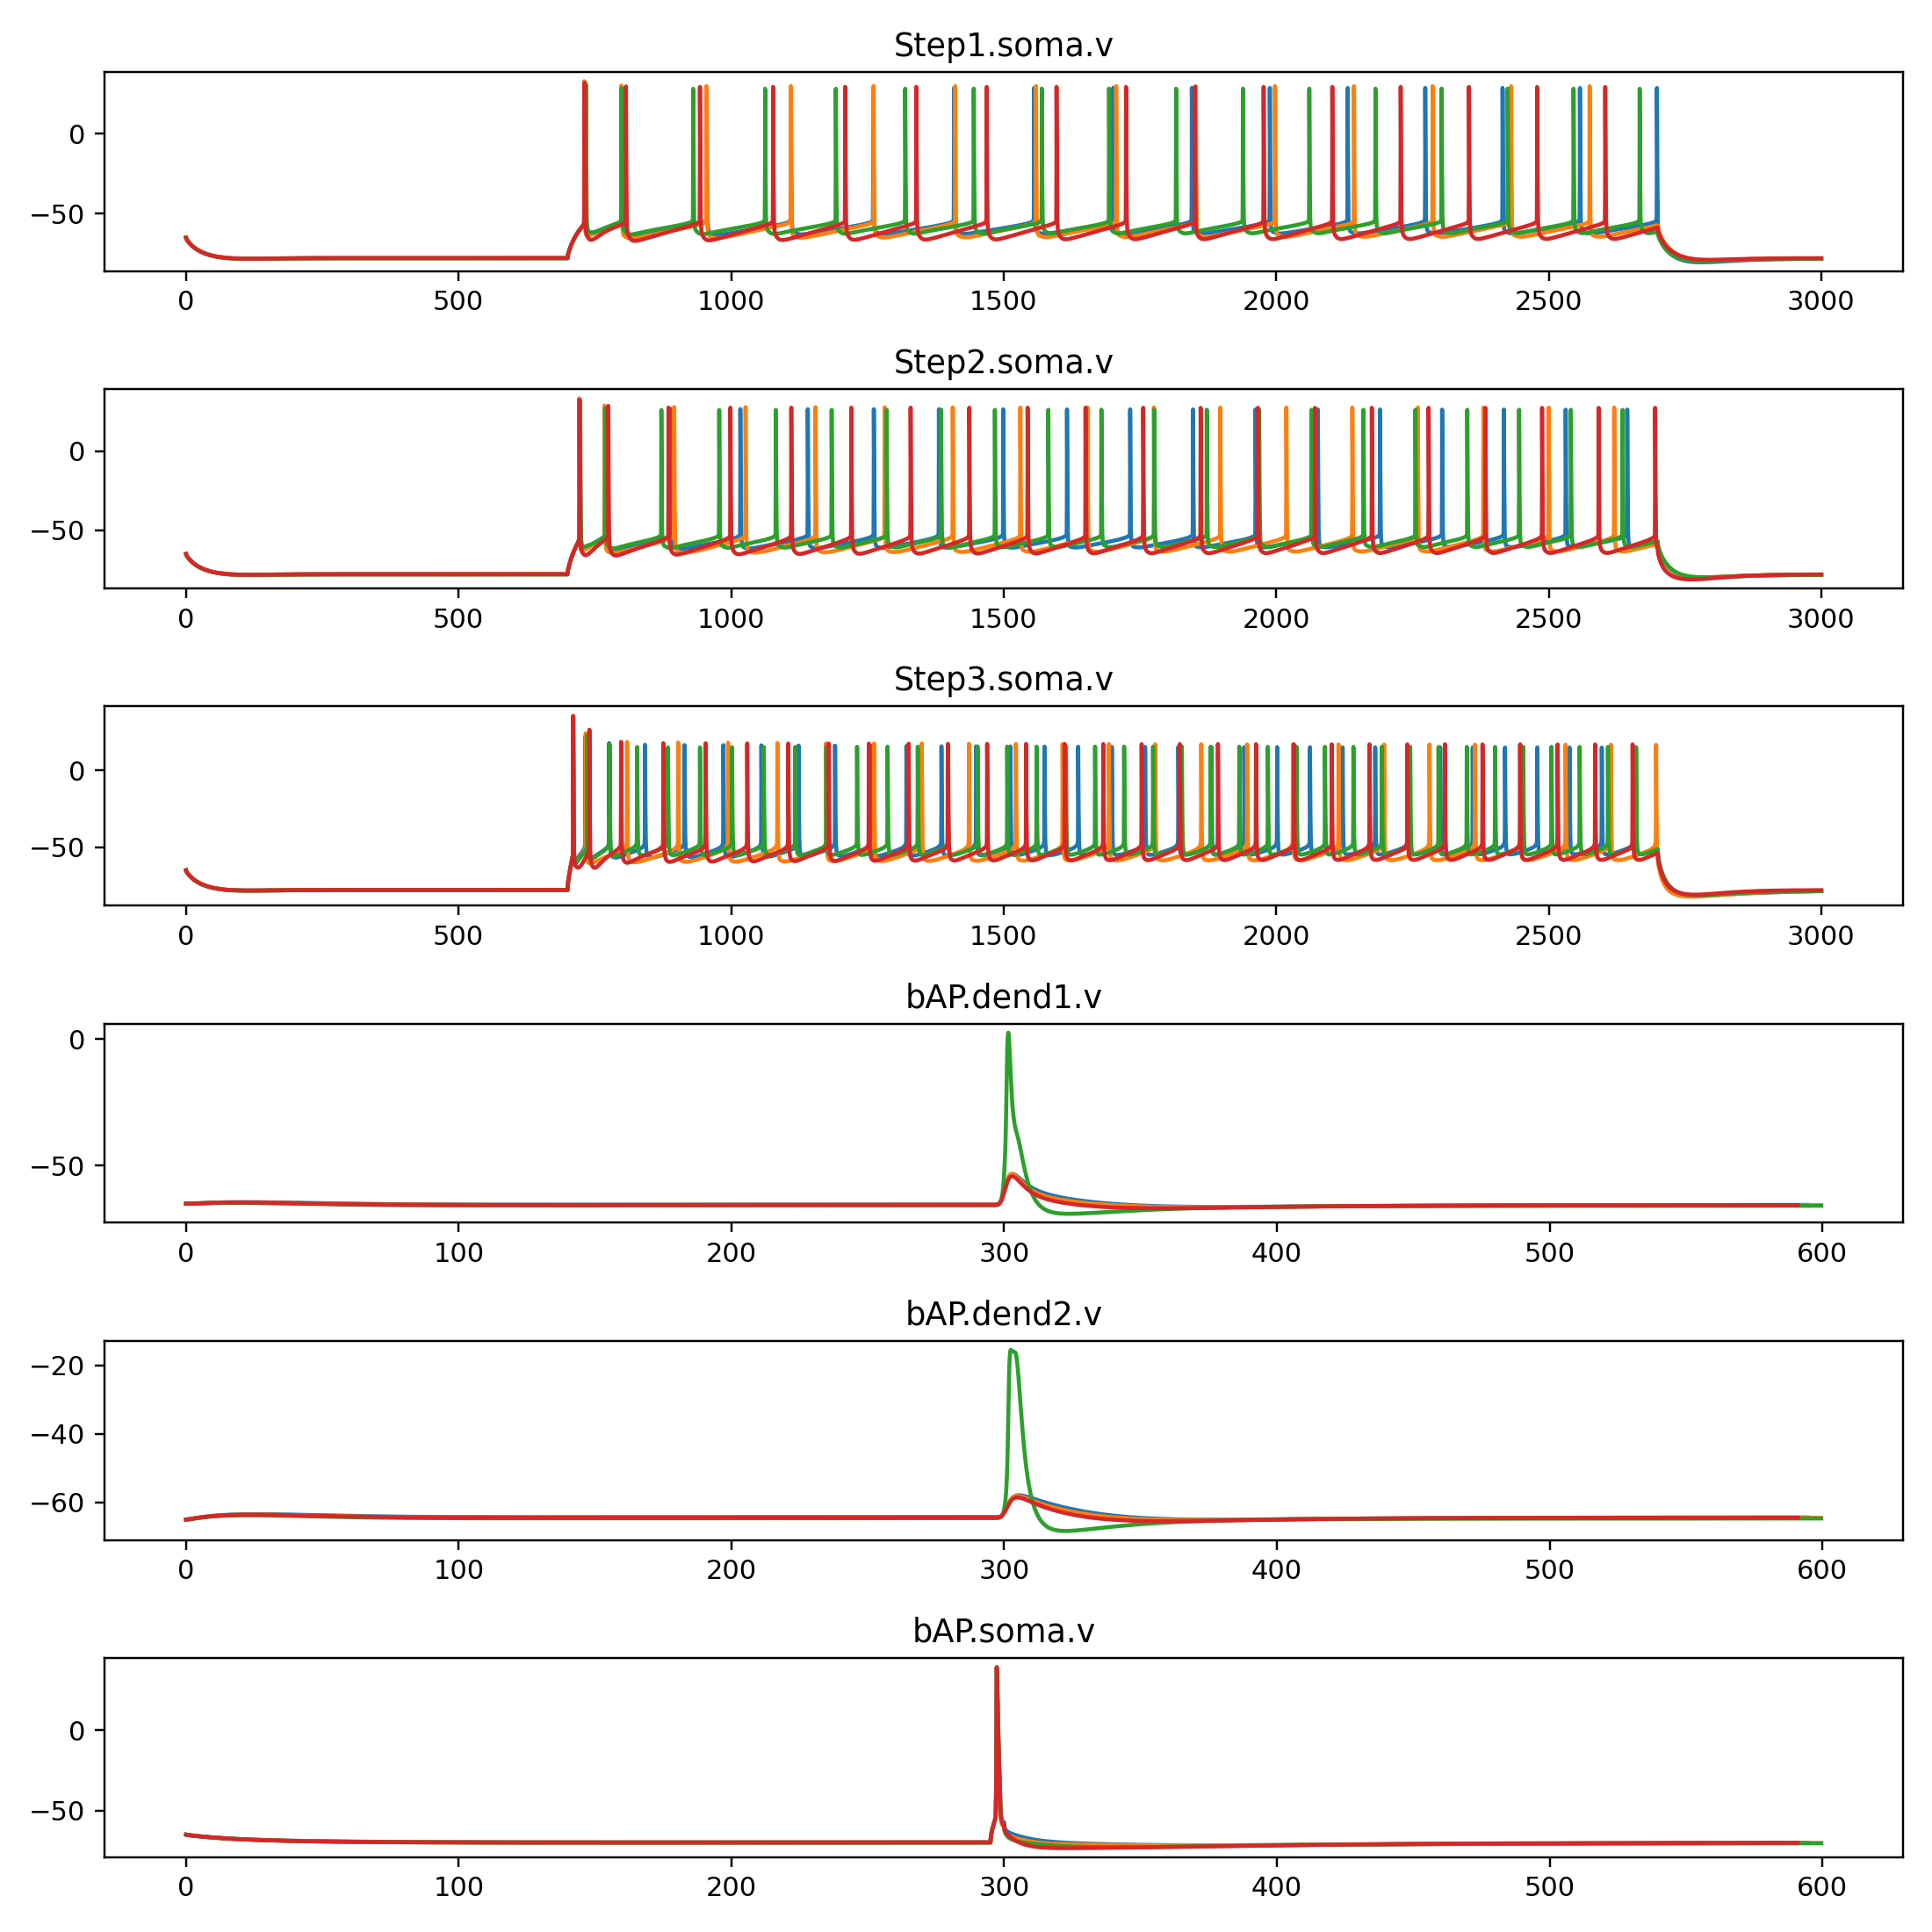

In [197]:
l5pc_plot.plot_multiple_responses([original_responses, best_responses_bap, best_responses_soma, best_responses_extra])

<IPython.core.display.Javascript object>


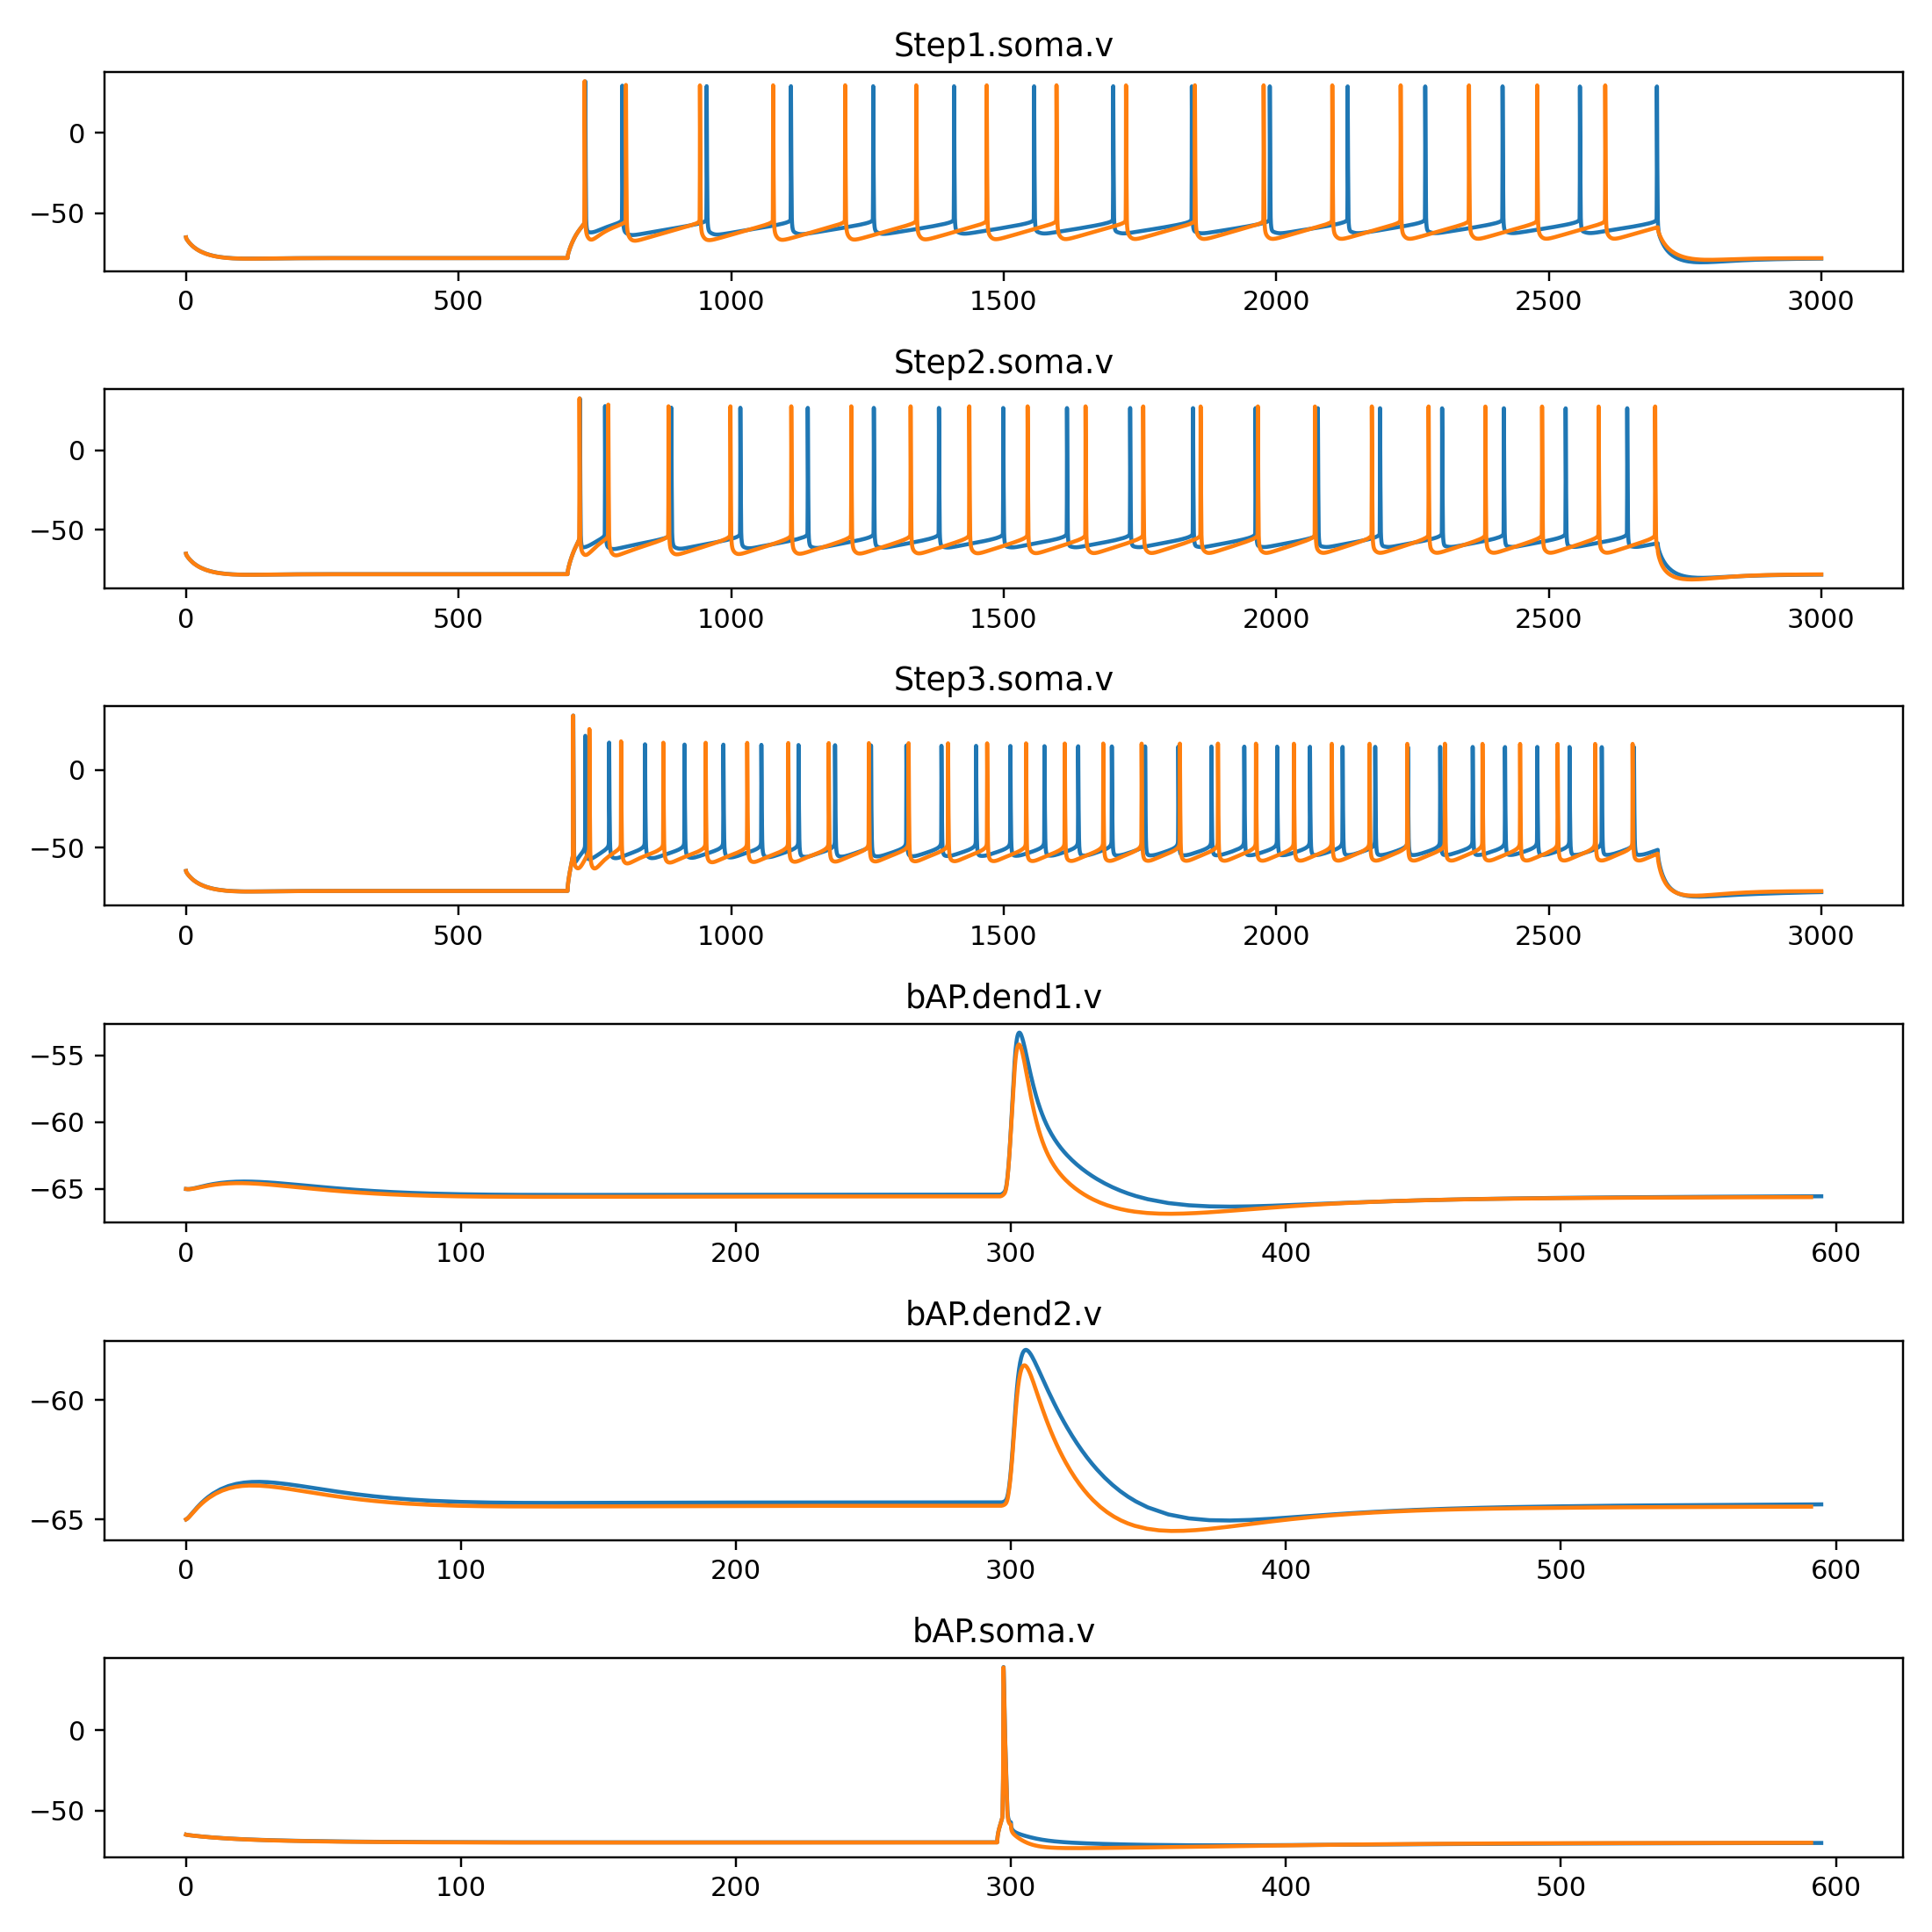

In [198]:
l5pc_plot.plot_multiple_responses([original_responses, best_responses_extra])

## Compare extracellular action potentials

In [199]:
## HELPER FUNCTIONS ##
def _construct_somatic_efel_trace(responses, somatic_recording_name, stim_start, stim_end):
    """Construct trace that can be passed to eFEL"""

    trace = {}
    if somatic_recording_name not in responses:
        return None

    if responses[somatic_recording_name] is None:
        return None

    response = responses[somatic_recording_name]

    trace['T'] = response['time']
    trace['V'] = response['voltage']
    trace['stim_start'] = [stim_start]
    trace['stim_end'] = [stim_end]

    return trace

def _setup_efel(threshold=None, interp_step=None, double_settings=None, int_settings=None):
    """Set up efel before extracting the feature"""

    import efel
    efel.reset()

    if threshold is not None:
        efel.setThreshold(threshold)

    if interp_step is not None:
        efel.setDoubleSetting('interp_step', interp_step)

    if double_settings is not None:
        for setting_name, setting_value in double_settings.items():
            efel.setDoubleSetting(setting_name, setting_value)

    if int_settings is not None:
        for setting_name, setting_value in int_settings.items():
            efel.setIntSetting(setting_name, setting_value)
            

def _get_peak_times(responses, somatic_recording_name, stim_start, stim_end, raise_warnings=False, **efel_kwargs):

    efel_trace = _construct_somatic_efel_trace(responses, somatic_recording_name, stim_start, stim_end)

    if efel_trace is None:
        peak_times = None
    else:
        _setup_efel(**efel_kwargs)

        import efel
        peaks = efel.getFeatureValues([efel_trace], ['peak_time'], raise_warnings=raise_warnings)
        peak_times = peaks[0]['peak_time']

        efel.reset()

    return peak_times

def _interpolate_response(response, fs=20.):
    from scipy.interpolate import interp1d

    x = response['time']
    y = response['voltage']
    f = interp1d(x, y, axis=1)
    xnew = np.arange(np.min(x), np.max(x), 1. / fs)
    ynew = f(xnew)  # use interpolation function returned by `interp1d`

    response_new = {}
    response_new['time'] = xnew
    response_new['voltage'] = ynew

    return response_new


def _filter_response(response, fcut=[0.5, 6000], order=2, filt_type='lfilter'):
    import scipy.signal as ss
    fs = 1 / np.mean(np.diff(response['time'])) * 1000
    fn = fs / 2.

    trace = response['voltage']

    if isinstance(fcut, (float, int, np.float, np.integer)):
        btype = 'highpass'
        band = fcut / fn
    else:
        assert isinstance(fcut, (list, np.ndarray)) and len(fcut) == 2
        btype = 'bandpass'
        band = np.array(fcut) / fn

    b, a = ss.butter(order, band, btype=btype)

    if len(trace.shape) == 2:
        if filt_type == 'filtfilt':
            filtered = ss.filtfilt(b, a, trace, axis=1)
        else:
            filtered = ss.lfilter(b, a, trace, axis=1)
    else:
        if filt_type == 'filtfilt':
            filtered = ss.filtfilt(b, a, trace)
        else:
            filtered = ss.lfilter(b, a, trace)

    response_new = {}
    response_new['time'] = response['time']
    response_new['voltage'] = filtered

    return response_new


def _upsample_wf(waveforms, upsample):
    from scipy.signal import resample_poly
    ndim = len(waveforms.shape)
    waveforms_up = resample_poly(waveforms, up=upsample, down=1, axis=ndim-1)

    return waveforms_up


def _get_waveforms(response, peak_times, snippet_len_ms):
    times = response['time']
    traces = response['voltage']

    assert np.std(np.diff(times)) < 0.001 * np.mean(np.diff(times)), "Sampling frequency must be constant"

    fs = 1. / np.mean(np.diff(times))  # kHz

    reference_frames = (peak_times * fs).astype(int)

    if isinstance(snippet_len_ms, (tuple, list, np.ndarray)):
        snippet_len_before = int(snippet_len_ms[0] * fs)
        snippet_len_after = int(snippet_len_ms[1] * fs)
    else:
        snippet_len_before = int((snippet_len_ms + 1) / 2 * fs)
        snippet_len_after = int((snippet_len_ms - snippet_len_before) * fs)

    num_snippets = len(peak_times)
    if len(traces.shape) == 2:
        num_channels = traces.shape[0]
    else:
        num_channels = 1
        traces = traces[np.newaxis, :]
    num_frames = len(times)
    snippet_len_total = int(snippet_len_before + snippet_len_after)
    waveforms = np.zeros((num_snippets, num_channels, snippet_len_total), dtype=traces.dtype)

    for i in range(num_snippets):
        snippet_chunk = np.zeros((num_channels, snippet_len_total), dtype=traces.dtype)
        if 0 <= reference_frames[i] < num_frames:
            snippet_range = np.array([int(reference_frames[i]) - snippet_len_before,
                                      int(reference_frames[i]) + snippet_len_after])
            snippet_buffer = np.array([0, snippet_len_total], dtype='int')
            # The following handles the out-of-bounds cases
            if snippet_range[0] < 0:
                snippet_buffer[0] -= snippet_range[0]
                snippet_range[0] -= snippet_range[0]
            if snippet_range[1] >= num_frames:
                snippet_buffer[1] -= snippet_range[1] - num_frames
                snippet_range[1] -= snippet_range[1] - num_frames
            snippet_chunk[:, snippet_buffer[0]:snippet_buffer[1]] = traces[:, snippet_range[0]:snippet_range[1]]
        waveforms[i] = snippet_chunk

    return waveforms

In [200]:
def calculate_eap(responses, protocol_name, protocols, fs=20, fcut=1,
                  ms_cut=[2, 10], upsample=10, skip_first_spike=True, skip_last_spike=True, 
                  raise_warnings=False, verbose=False, **efel_kwargs):
    
    assert "Step" in protocol_name
    stimulus = protocols[protocol_name].stimuli[0]
    stim_start = stimulus.step_delay
    stim_end = stimulus.step_delay + stimulus.step_duration
    efel_kwargs['threshold'] = -20
    
    somatic_recording_name = f'{protocol_name}.soma.v'
    extra_recording_name = f'{protocol_name}.MEA.LFP'
    
    peak_times = _get_peak_times(responses, somatic_recording_name, stim_start, stim_end,
                                 raise_warnings=raise_warnings, **efel_kwargs)

    if len(peak_times) > 1 and skip_first_spike:
        peak_times = peak_times[1:]

    if len(peak_times) > 1 and skip_last_spike:
        peak_times = peak_times[:-1]
        
    if responses[extra_recording_name] is not None:
        response = responses[extra_recording_name]
    else:
        return None

    if np.std(np.diff(response['time'])) > 0.001 * np.mean(np.diff(response['time'])):
        assert fs is not None
        if verbose:
            print('interpolate')
        response_interp = _interpolate_response(response, fs=fs)
    else:
        response_interp = response

    if fcut is not None:
        if verbose:
            print('filter enabled')
        response_filter = _filter_response(response_interp, fcut=fcut)
    else:
        if verbose:
            print('filter disabled')
        response_filter = response_interp

    ewf = _get_waveforms(response_filter, peak_times, ms_cut)
    mean_wf = np.mean(ewf, axis=0)
    if upsample is not None:
        if verbose:
            print('upsample')
        assert upsample > 0
        upsample = int(upsample)
        mean_wf_up = _upsample_wf(mean_wf, upsample)
        fs_up = upsample * fs
    else:
        mean_wf_up = mean_wf
        fs_up = fs

    return mean_wf_up

In [201]:
mean_wf_extra = calculate_eap(best_responses_extra, "Step1", evaluator.fitness_protocols) * 1000
mean_wf_bap = calculate_eap(best_responses_bap, "Step1", evaluator.fitness_protocols) * 1000
mean_wf_soma = calculate_eap(best_responses_soma, "Step1", evaluator.fitness_protocols) * 1000
mean_wf_original = calculate_eap(original_responses, "Step1", evaluator.fitness_protocols) * 1000

In [202]:
mean_wf_extra_n = mean_wf_extra / np.max(np.abs(mean_wf_extra), 1, keepdims=True)
mean_wf_bap_n = mean_wf_extra / np.max(np.abs(mean_wf_bap), 1, keepdims=True)
mean_wf_soma_n = mean_wf_extra / np.max(np.abs(mean_wf_soma), 1, keepdims=True)
mean_wf_original_n = mean_wf_extra / np.max(np.abs(mean_wf_original), 1, keepdims=True)

In [203]:
probe_file = Path('config') / 'features' / f'random_{sample_id}'/ 'probe.json'
probe, electrode = l5pc_evaluator.define_electrode(probe_file)

In [204]:
vscale = 1.5 * np.max(np.abs(mean_wf_original_n))

<IPython.core.display.Javascript object>


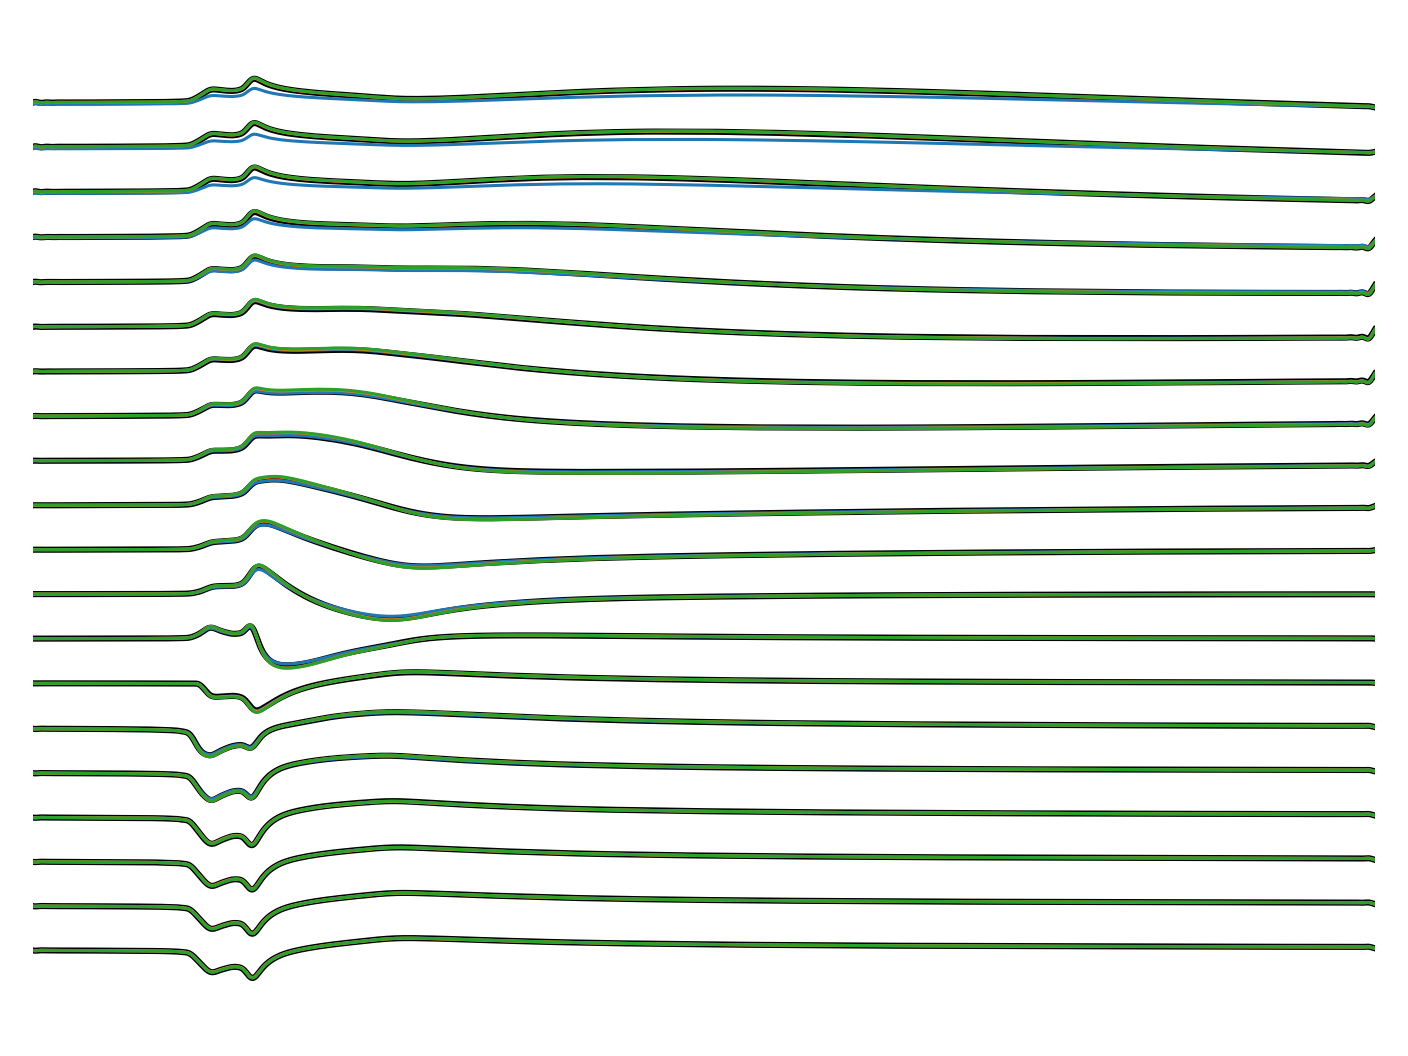

In [205]:
ax_extra = mu.plot_mea_recording(mean_wf_original_n, probe, colors='k', lw=2)
mu.plot_mea_recording(mean_wf_soma_n, probe, colors='C0', ax=ax_extra)
mu.plot_mea_recording(mean_wf_bap_n, probe, colors='C1', ax=ax_extra)
mu.plot_mea_recording(mean_wf_extra_n, probe, colors='C2', ax=ax_extra)

## Capability of the models to reproduce BAP-activated calcium spikes?

It would be nice to show some functional output. 